# Explicabilidade

Os gráficos SHAP (SHapley Additive exPlanations) são uma boa forma de visualizar a importancia das features utilizadas e tirar insights de como as features estão ajudando o modelo a prever o target.

Plota-se abaixo alguns gráficos SHAP para se obter mais insights sobre as features e seu impacto na predição do target.

Para plotar os gráficos abaixo, precisa-se dos seguintes artefatos gerados nos notebooks anteriores:

- shap_values
    - caminho: '../data/08_reporting/<nome_do_arquivo>.npy'

- X_test_scaled
    - caminho: '../data/03_primary/<nome_do_arquivo>.npy'

- selected_features
    - caminho: '../data/08_reporting/<nome_do_arquivo>.npy'

- modelo
    -  caminho: '../data/06_models/<nome_do_arquivo>.joblib'

- explainer
    - caminho: '../data/08_reporting/<nome_do_arquivo>.pkl'
    


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib #Para salvar o modelo 
from scipy.stats import uniform, randint # Para a distribuição de parâmetros

import pickle
import os, random
import utils
from functools import partial



In [11]:

existing_model_shap_all_features = True

existing_model_shap_non_linear_features = True

existing_model_shap_linear_features = False


# Features selecionadas

caminho_features_selecionadas_all_features = '../data/08_reporting/selected_features_all_features.npy'

caminho_features_selecionadas_non_linear_features = '../data/08_reporting/selected_non_linear_features.npy'

caminho_features_selecionadas_linear_features = '../data/08_reporting/selected_linear_features_features.npy'

# Caso os dvalores shapa já estejam calculados

caminho_shap_all_features = '../data/08_reporting/shap_values_calculados_all_features.npy'

caminho_shap_non_linear_features = '../data/08_reporting/shap_values_calculados.npy'

caminho_shap_linear_features = '../data/08_reporting/shap_values_calculados_linear_features.npy'

# Conjunto de treino normalizado para plotar o gráfico

caminho_X_train_all_features = '../data/03_primary/X_train_all_features.npy'

caminho_X_train_non_linear_features = '../data/03_primary/X_train_non_linear_features.npy'

caminho_X_train_linear_features = '../data/03_primary/X_train_linear_features.npy'

# Target de treino normalizado

caminho_y_train_all_features = '../data/03_primary/y_train_all_features.npy'

caminho_y_train_non_linear_features = '../data/03_primary/y_train_non_linear_features.npy'

caminho_y_train_linear_features = '../data/03_primary/y_train_linear_features.npy'

# Conjunto de teste normalizado para plotar o gráfico

caminho_X_test_shap_all_features = '../data/03_primary/X_test_final_para_shap_all_features.npy'

caminho_X_test_shap_non_linear_features = '../data/03_primary/X_test_final_para_shap.npy'

caminho_X_test_shap_linear_features = '../data/03_primary/X_test_final_para_shap_linear_features.npy'

# Target de teste normalizado

caminho_y_teste_shap_all_features = '../data/03_primary/y_test_final_para_shap_all_features.npy'

caminho_y_teste_shap_non_linear_features = '../data/03_primary/y_test_final_para_shap_non_linear_features.npy'

caminho_y_teste_shap_linear_features = '../data/03_primary/y_test_final_para_shap_linear_features.npy'

# shap explainers

caminho_explainer_all_features = '../data/08_reporting/explainer_expected_value_all_features.pkl'

caminho_explainer_non_linear_features = '../data/08_reporting/explainer_expected_value.pkl'

caminho_explainer_linear_features = '../data/08_reporting/explainer_expected_value_linear_features.pkl'

# modelos

caminho_modelo_all_features = '../data/06_models/modelo_notebook_2_all_data.joblib'

caminho_modelo_non_linear_features = '../data/06_models/modelo_notebook_3.joblib'

caminho_modelo_linear_features = '../data/06_models/modelo_notebook_4.joblib'

# 1 - Modelo com todas as features

In [12]:
X_test_scaled = np.load(caminho_X_test_shap_all_features, allow_pickle=True)

y_test_scaled = np.load(caminho_y_teste_shap_all_features, allow_pickle=True)

with open(caminho_features_selecionadas_all_features, 'rb') as f:
    loaded_data = pickle.load(f)

selected_feature_names = loaded_data['list']

with open(caminho_modelo_all_features, 'rb') as f:
    best_nn_model = joblib.load(f)


if existing_model_shap_all_features:
    # Carregar os valores salvos
    shap_values = np.load(caminho_shap_all_features, allow_pickle=True)
    
    with open(caminho_explainer_all_features, 'rb') as f:
        explainer = pickle.load(f)
    
else:

    X_train_scaled = np.load(caminho_X_train_all_features, allow_pickle=True)

    # O KernelExplainer usa um "background dataset" para calcular a linha de base.
    # Recomenda-se usar uma pequena amostra aleatória dos dados de treino ou teste.
    X_background = shap.sample(X_train_scaled, 100) # Amostra de 100 observações

    # --- Definir o Explainer ---
    # O KernelExplainer funciona com qualquer modelo, mas requer uma função preditiva.
    # Assumindo que seu modelo se chama 'model_rn'
    explainer = shap.KernelExplainer(
        best_nn_model.predict, 
        X_background
    )

    # --- Calcular os Valores SHAP ---
    # Calcule os valores para o seu conjunto de teste (X_test_final).
    # Isso pode ser demorado (pode levar minutos ou horas, dependendo do tamanho de X_test_final)
    shap_values = explainer.shap_values(X_test_scaled)

    # Salvar os shap_values
    np.save(caminho_shap_all_features, shap_values)

    with open(caminho_explainer_all_features, 'wb') as f:
        pickle.dump(explainer, f)

    
    

In [13]:
X_test_scaled

array([[0.07435633, 0.03692665, 0.07820612, ..., 0.67787304, 0.75516848,
        0.58506933],
       [0.0345022 , 0.04971428, 0.16655969, ..., 0.43809408, 0.61857454,
        0.60499934],
       [0.04625197, 0.02367464, 0.03390572, ..., 0.46693009, 0.22309948,
        0.68884533],
       ...,
       [0.05592865, 0.0164072 , 0.03009316, ..., 0.54483773, 0.74733535,
        0.3456188 ],
       [0.00669132, 0.03854449, 0.02475963, ..., 0.37918641, 0.43993221,
        0.2583734 ],
       [0.02253857, 0.03226719, 0.0216271 , ..., 0.57681082, 0.50620491,
        0.50459419]], shape=(2000, 510))

In [14]:
X_test_scaled

array([[0.07435633, 0.03692665, 0.07820612, ..., 0.67787304, 0.75516848,
        0.58506933],
       [0.0345022 , 0.04971428, 0.16655969, ..., 0.43809408, 0.61857454,
        0.60499934],
       [0.04625197, 0.02367464, 0.03390572, ..., 0.46693009, 0.22309948,
        0.68884533],
       ...,
       [0.05592865, 0.0164072 , 0.03009316, ..., 0.54483773, 0.74733535,
        0.3456188 ],
       [0.00669132, 0.03854449, 0.02475963, ..., 0.37918641, 0.43993221,
        0.2583734 ],
       [0.02253857, 0.03226719, 0.0216271 , ..., 0.57681082, 0.50620491,
        0.50459419]], shape=(2000, 510))

In [15]:
selected_feature_names

Index(['l_2', 'l_3', 'l_4', 'l_5', 'l_6', 'l_7', 'l_8', 'l_9', 'l_10', 'l_11',
       ...
       'l_502', 'l_503', 'l_504', 'l_505', 'l_506', 'l_507', 'l_508', 'l_509',
       'l_510', 'l_511'],
      dtype='object', length=510)

## 1.1 - Gráfico de Resumo Global (Summary Plot - Importância das Features)

Este é o gráfico mais importante e mostra a importância global das features.

    - Eixo Y: Features ordenadas por importância.

    - Eixo X: Valor SHAP.

    - Cor: Valor da feature (azul = baixo valor da feature, vermelho = alto valor da feature).

In [16]:
# Supondo que você usou o código abaixo para definir shap_values_plot
if isinstance(shap_values, list):
    shap_values_plot = shap_values[0]
else:
    shap_values_plot = shap_values

print(f"Tipo de shap_values_plot: {type(shap_values_plot)}")
print(f"Shape de shap_values_plot: {shap_values_plot.shape}")
print(f"Número de Features esperadas: {len(selected_feature_names)}") # Use o nome da sua lista de features

Tipo de shap_values_plot: <class 'numpy.ndarray'>
Shape de shap_values_plot: (2000, 510, 1)
Número de Features esperadas: 510


Novo Shape de shap_values_plot: (2000, 510)


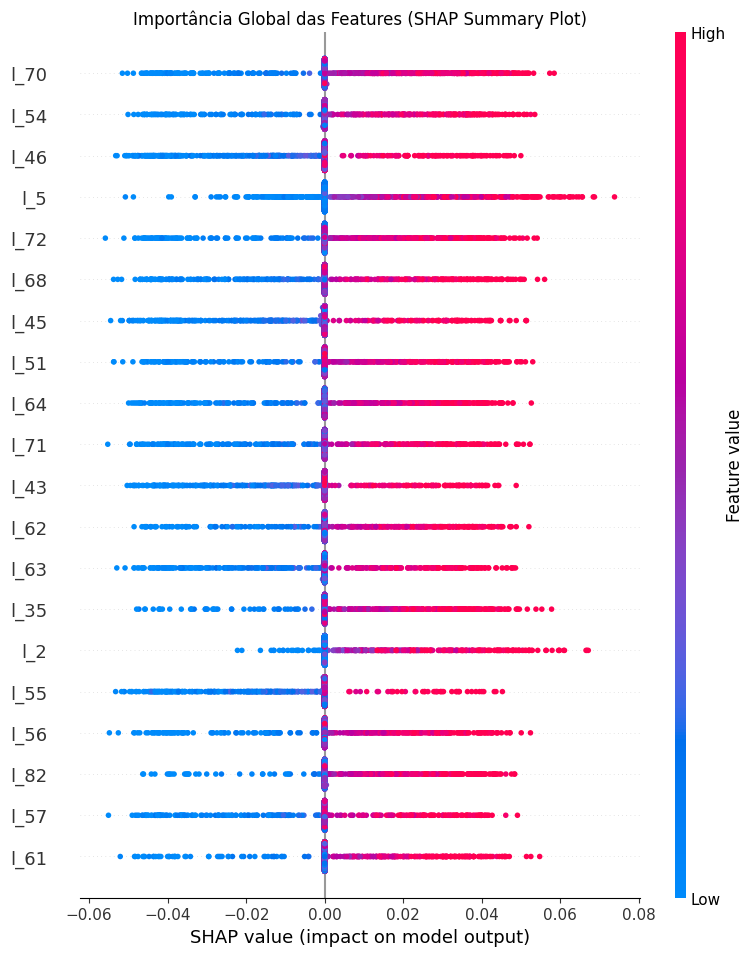

In [17]:
if isinstance(shap_values, list):
    # Pega o primeiro elemento da lista 
    shap_values_array = shap_values[0]
else:
    shap_values_array = shap_values

# ACHATA o array de (2000, 510, 1) para (2000, 510)
shap_values_plot = np.squeeze(shap_values_array)

# Verificação após o squeeze 
print(f"Novo Shape de shap_values_plot: {shap_values_plot.shape}") 

# --- Geração do Gráfico ---

shap.summary_plot(
    shap_values_plot, 
    X_test_scaled, 
    feature_names=selected_feature_names,
    show=False 
)
plt.title("Importância Global das Features (SHAP Summary Plot)")
plt.show()

# Salvar a imagem. O formato é determinado pela extensão (.png, .jpg, .pdf, .svg)
plt.savefig(
    '../data/08_reporting/shap_summary_plot_all_features.png', 
    dpi=300,        # Alta resolução para qualidade de relatório
    bbox_inches='tight' # Garante que todos os rótulos e eixos sejam incluídos
)
plt.clf() # Limpa o Matplotlib Figure para o próximo gráfico (opcional, mas recomendado)
plt.close() # Fecha a figura (libera memória)

### Explicação do gráfico acima

O Gráfico de Resumo SHAP é a maneira mais concisa de entender a importância e a direção do impacto de cada feature nas previsões.


- Eixo Y: Lista as features (variáveis de entrada), ordenadas da mais importante (topo) para a menos importante (base), com base na magnitude média dos seus valores SHAP.

- Eixo X: Representa o Valor SHAP. Este valor indica a contribuição (positiva ou negativa) de uma feature para a previsão do modelo em relação ao valor de previsão base (média).

- Cor do Ponto: Representa o valor real da feature para aquela observação. Geralmente, Vermelho = Alto Valor da Feature (Alto na escala escalada) e Azul = Baixo Valor da Feature (Baixo na escala escalada).

- Dispersão dos Pontos,Cada ponto é uma observação individual do conjunto de teste. A dispersão horizontal mostra o quão variável é o impacto dessa feature entre as observações. Quanto maior a dispersão de uma feature que já foi avaliada como importante, maior é a interação entre as features do modelo.




### Significado Visual do Gráfico

- Linha de Base: O ponto central, geralmente rotulado como E[f(x)] (o Valor Base/Média, 0.5108), é o ponto de partida da previsão.

- Setas Vermelhas (Forças Positivas): Representam as features que estão aumentando o valor da previsão, empurrando-a para a direita em direção ao valor mais alto.

- Setas Azuis (Forças Negativas): Representam as features que estão diminuindo o valor da previsão, empurrando-a para a esquerda em direção ao valor mais baixo.

- Comprimento da Seta: Indica a magnitude do impacto daquela feature. Setas mais longas significam uma contribuição mais forte.

### Interpretação dos Resultados da Observação 0

A previsão de r (0.2748) é significativamente inferior ao valor médio (0.5108).

Isto implica que, para esta observação específica, o modelo identificou que as características predominantes (setas azuis) puxaram a previsão para baixo, resultando em uma estimativa de r bem abaixo da média.

## 1.2 - Gráfico de Força (Force Plot - Explicação Local)

O gráfico abaixo explica uma única previsão. Ele mostra como cada feature empurra a previsão da linha de base (valor médio) para o valor final previsto.

In [18]:
observation_index = 0
X_test_scaled[observation_index:observation_index+1]

array([[0.07435633, 0.03692665, 0.07820612, 0.10753174, 0.06924267,
        0.04735033, 0.13221722, 0.03080519, 0.11091607, 0.06976573,
        0.07511814, 0.12166089, 0.15099572, 0.28655289, 0.12569991,
        0.27902416, 0.15574104, 0.1889814 , 0.22124128, 0.22601486,
        0.24417702, 0.15954468, 0.20592853, 0.11277245, 0.1876696 ,
        0.23844294, 0.20630076, 0.19734306, 0.21048164, 0.11718886,
        0.27797011, 0.20280968, 0.14128858, 0.17715666, 0.1372289 ,
        0.29830199, 0.21431629, 0.25163434, 0.27665795, 0.21886861,
        0.2456111 , 0.19933972, 0.20450524, 0.18538858, 0.22200547,
        0.22783986, 0.20510313, 0.21137358, 0.22325121, 0.32577575,
        0.18488168, 0.23740614, 0.20680809, 0.13376455, 0.25150128,
        0.1709436 , 0.21756154, 0.17902226, 0.2372875 , 0.17655513,
        0.30037873, 0.17916029, 0.23035571, 0.18015026, 0.28507387,
        0.26328434, 0.2630134 , 0.38646146, 0.36463916, 0.22627463,
        0.25501688, 0.21537819, 0.19581698, 0.34

In [19]:
selected_feature_names

Index(['l_2', 'l_3', 'l_4', 'l_5', 'l_6', 'l_7', 'l_8', 'l_9', 'l_10', 'l_11',
       ...
       'l_502', 'l_503', 'l_504', 'l_505', 'l_506', 'l_507', 'l_508', 'l_509',
       'l_510', 'l_511'],
      dtype='object', length=510)

In [20]:
with open(caminho_explainer_all_features, 'rb') as f:
    expected_value = pickle.load(f)

In [21]:
expected_value

array([0.45331917])


Explicação para a Observação 0:
Valor Base (Média): 0.4533
Valor Previsto: 0.2599


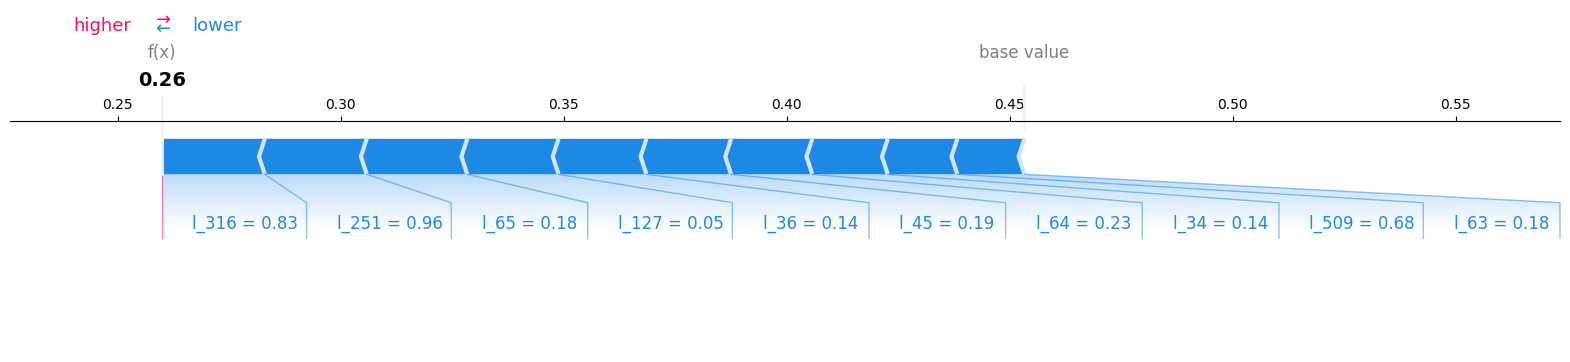

In [22]:
observation_index = 0

# Acessa os valores da feature (a linha de dados)
# Funciona para NumPy Array e Pandas DataFrame/Series
if hasattr(X_test_scaled, 'iloc'):
    # Se for DataFrame, pega a linha como Series para o Force Plot
    X_obs_values_raw = X_test_scaled.iloc[observation_index]
else:
    # Se for Array NumPy, apenas pega a linha (será um array 1D)
    X_obs_values_raw = X_test_scaled[observation_index]


# ARREDONDAR PARA DUAS CASAS DECIMAIS
X_obs_values = np.round(X_obs_values_raw, 2)

# --- 2. Preparação para Print e Predição ---

# Para predição, o modelo sempre espera uma entrada 2D (mesmo para 1 observação)
X_obs_for_prediction = X_test_scaled[observation_index:observation_index+1]
predicted_value = best_nn_model.predict(X_obs_for_prediction)[0]

print(f"\nExplicação para a Observação {observation_index}:")
print(f"Valor Base (Média): {expected_value[0] :.4f}")         #explainer.expected_value[0]:.4f}") # Formata o valor base
print(f"Valor Previsto: {predicted_value[0]:.4f}") # Formata o valor previsto


# --- 3. Geração e Salvamento do Force Plot ---

# shap_values_plot[observation_index] é o array 1D dos valores SHAP para esta observação
shap.force_plot(
    expected_value[0], #explainer.expected_value,
    shap_values_plot[observation_index],
    X_obs_values, # Os valores da feature para a observação
    feature_names=selected_feature_names, # Passe a lista de nomes explicitamente
    matplotlib=True,
    #show=False
)

# Salvar a figura atual do Matplotlib
plt.savefig(
    f'../data/08_reporting/shap_force_plot_obs_{observation_index}_all_features.png', 
    dpi=300, 
    bbox_inches='tight'
)
plt.clf()
plt.close()

## Explicação do gráfico acima

O Force Plot (Gráfico de Força) fornece uma explicação local, detalhando exatamente como cada feature da Observação 0 contribuiu para a previsão final do modelo.

A observação 0 é a primeira linha do dataset.

- Valor Base (Média): 0.4533,
    - Significado: É a previsão média de r (ou a média dos targets escalados) para todo o conjunto de dados. Representa o ponto de partida do modelo antes de considerar as features específicas da observação.
- Valor Previsto: 0.2599
    - Significado: É o valor final previsto para r pelo modelo, após considerar todas as features específicas da Observação 0."

## Significado Visual do Gráfico

- Linha de Base: O ponto central, geralmente rotulado como E[f(x)] (o Valor Base/Média, 0.5108), é o ponto de partida da previsão.

- Setas Vermelhas (Forças Positivas): Representam as features que estão aumentando o valor da previsão, empurrando-a para a direita em direção ao valor mais alto.

- Setas Azuis (Forças Negativas): Representam as features que estão diminuindo o valor da previsão, empurrando-a para a esquerda em direção ao valor mais baixo.

- Comprimento da Seta: Indica a magnitude do impacto daquela feature. Setas mais longas significam uma contribuição mais forte.

## Interpretação dos Resultados da Observação 0

A previsão de r (0.2599) é significativamente inferior ao valor médio (0.4533).

Isto implica que, para esta observação específica, o modelo identificou que as características predominantes (setas azuis) puxaram a previsão para baixo, resultando em uma estimativa de r bem abaixo da média.

## Observação

- Um valor longe do valor médio, como mostrado no gráfico acima, não indica que o resultado foi ruim.

- Podemos ver nas linhas de código abaixo que o valor `y_test_scaled`, que é o valor real normalizado, ficou próximo do valor normalizado previsto pelo modelo.

In [24]:
y_test_scaled[0]

array([0.24033362])

## 6.3 - Gráfico de Dependência (Dependence Plot - Relação Feature-Target)

O gráfico abaixo ajuda a entender a forma (linear ou não linear) da relação entre uma feature e o target.

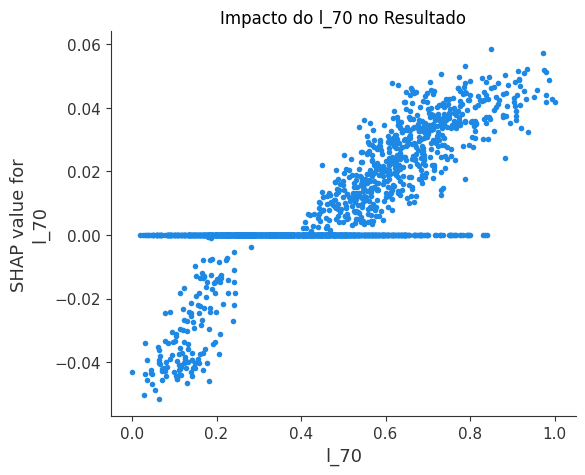

In [26]:
# Explicando a relação da feature mais importante 
most_important_feature = 'l_70' # Substitua pelo nome da sua feature principal

shap.dependence_plot(
    most_important_feature, 
    shap_values_plot, 
    X_test_scaled, 
    interaction_index=None, # Não mostra interação com outra feature
    show=False,
    feature_names=selected_feature_names
)
plt.title(f"Impacto do {most_important_feature} no Resultado")
plt.show()


plt.savefig(
    f'../data/08_reporting/shap_dependence_plot_{most_important_feature}_all_features.png', 
    dpi=300, 
    bbox_inches='tight'
)
plt.clf()
plt.close()